In [1]:
import numpy as np
import scipy.special as scs
from sympy import *

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

init_session()

IPython console for SymPy 1.5.1 (Python 3.6.0-64-bit) (ground types: python)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.5.1/



### 二乗誤差による直線近似

f(x)=ax+b

として、直線近似したい点群の値を代入したときに  
二乗誤差が一番小さくなるよう(a, b)を決定する  
→　a, bについて偏微分し、全ての点群(x_n,y_n)を代入したときに、  
なるべく 0 になる(a, b)を計算

In [2]:
points = [(107, 101), (449, 617), (816, 876), (1105,1153)]

In [3]:
### 変数の作成
a, b = symbols("a b")

### 評価式
j = (y - (a * x + b)) ** 2
j

In [4]:
### 評価式を変数で偏微分
j_a = diff(j, a)
j_b = diff(j, b)
j_a, j_b

In [5]:
### 各点の値を代入し、総和を取る (xは init_session()で定義されるので、シンボル化不要)
sum_a = sum([j_a.subs([(x, _x), (y, _y)]) for _x, _y in points])
sum_b = sum([j_b.subs([(x, _x), (y, _y)]) for _x, _y in points])
sum_a, sum_b

In [6]:
res = solve([sum_a, sum_b], [a, b])
res

In [7]:
float(res[a]), float(res[b])

### ベジェ曲線の制御点を通るように、制御点の補正値を求める

3次のbernstein多項式は  
bz = p_0 × (1-t)^3 + 3 × p_1 × t × (1-t)^2 + 3 × p_2 × t^2 × (1-t) + p_3 × t^3  
と表されるが、

bz : ベジェ曲線近似式  
px : 各ポイントにおける補正後のy座標  
とすると、評価式は

j=(px−bz)^2

になるので、ベジェ曲線近似式における制御点のy座標を変数とみなし(target_variable)、  
その変数で偏微分を行い、評価式が最小となるものを求める。  
(ただし、始点と終点を通る式である必要があるため、上の式でいう(p_0, p_3)は補正を行わない)


式の途中でtに代入する値が制御点のxの値そのままになっているが、修正する必要あり

In [28]:
points = np.array([(0, 0), (0.2, 65), (0.7, 45), (1.0, 100)])

In [29]:
def make_target_variables(points):
    n = len(points)
    variable_str = ""
    for i in range(n):
        variable_str += "p{} ".format(i)
    
    return symbols(variable_str)

In [30]:
def bernstein_polynomial(target_variables, t):
    n = len(target_variables)
    bz = 0
    for i in range(n):
        bz += scs.comb(n-1, i) * t**i * (1 - t)**(n-1-i) * target_variables[i]
    return bz

def mse_func(bz, px):
    return (px - bz) ** 2

def get_partial_differential(j, target_variables):
    differentials = []
    for variable in target_variables:
        differentials.append(simplify(diff(j, variable) / 2))
    return differentials



# まず、ポイントに対する変数を作成 (tやpxを含めて)
target_variables = make_target_variables(points)
px, t = symbols("px t")

# ベジェ曲線近似式
bz = bernstein_polynomial(target_variables, t)
# bz = (1-t)**3*target_variables[0] + \
#     3*(1-t)**2*t*target_variables[1] + \
#     3*(1-t)*t**2*target_variables[2] + \
#     t**3*target_variables[3]

# 評価式
j = mse_func(bz, px)

# 偏微分
jps = get_partial_differential(j, target_variables[1:-1])

In [31]:
bz

In [32]:
jps

In [33]:
# p0 p3 を始点と終点にする
const = ((target_variables[0], points[0][1]), (target_variables[-1], points[-1][1]))
equations = [sum([jp.subs(const + ((t, x[0]), (px, x[1]))) for x in points[1:-1]]) for jp in jps]
### tに代入する値が制御点のxの値そのままになっているが、修正する必要あり

res = solve(equations, target_variables[1:-1])
res

In [34]:
equations

In [35]:
float(res[target_variables[1]]), float(res[target_variables[2]])

In [36]:
def replace_points(points, res, target_variables):
    p = np.copy(points)
    for i in range(1, len(points)-1):
        p[i][1] = float(res[target_variables[i]])
    
    return p

In [37]:
new_points = replace_points(points, res, target_variables)

In [38]:
new_points

array([[  0.        ,   0.        ],
       [  0.2       , 180.45634921],
       [  0.7       , -53.07539683],
       [  1.        , 100.        ]])

In [39]:
### バーンシュタイン基底関数 : (t + (1 - t))^n のうち、指定された一つの項を返す
def bernstein(n, i, t):
    return scs.comb(n, i) * t**i * (1 - t)**(n-i)

### バーンシュタイン多項式 : (t + (1 - t))^n の全項を返す(リスト)
def bernstein_whole(n, t):
    return np.asarray([bernstein(n, i, t) for i in range(n + 1)])


### 制御点(始点・終点含む)をN点与えると、始点と終点を通るNー1次曲線の中の一点を返す(tの値に対応した値)
# def _bezier(n, t, q):
#     p = np.dot([bernstein(n, i, t) for i in range(n + 1)], q)
#     return p

def bezier(t, q):
    n = q.shape[0] - 1
    p = np.dot(bernstein_whole(n,t), q)
    return p

### 制御点(始点・終点含む)をN点与えると、始点と終点を通るNー1次曲線を返す
def bezier_curve(q):
    return np.asarray([bezier(t, q) for t in np.linspace(0, 1, 1000)])

In [45]:
P = bezier_curve(new_points)

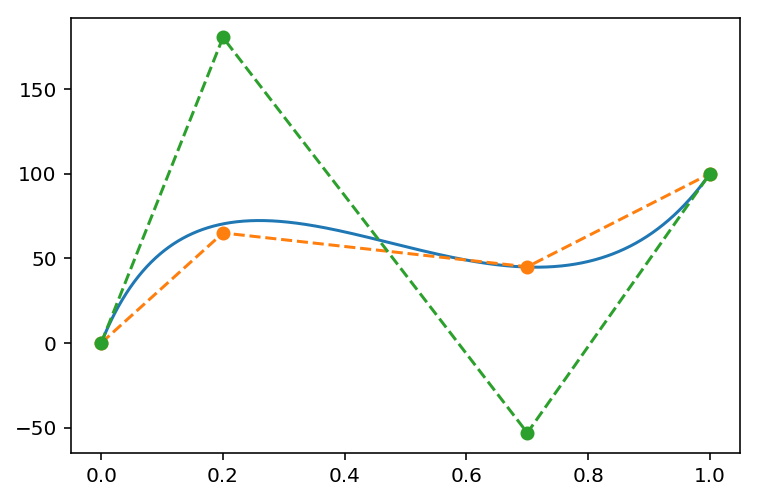

<Figure size 432x288 with 0 Axes>

In [46]:
### 制御点と対応するベジェ曲線のグラフ
plt.plot(P.T[0], P.T[1])
plt.plot(points.T[0], points.T[1], '--o')
plt.plot(new_points.T[0], new_points.T[1], '--o')
plt.show()
plt.clf()

In [47]:
another_points = np.array([(0, 0), (2, 65), (7, 45), (10, 100)])

In [48]:
Q = bezier_curve(another_points)

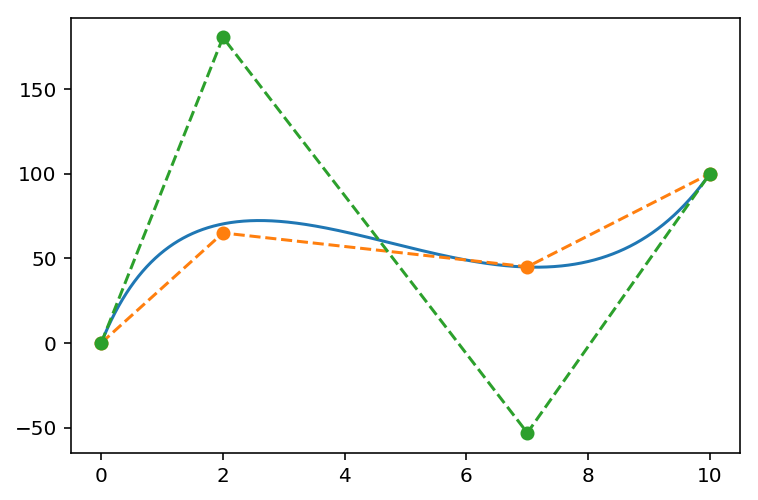

<Figure size 432x288 with 0 Axes>

In [49]:
plt.plot(Q.T[0], P.T[1])
plt.plot(another_points.T[0], points.T[1], '--o')
plt.plot(another_points.T[0], new_points.T[1], '--o')
plt.show()
plt.clf()

In [42]:
P = bezier_curve(points)

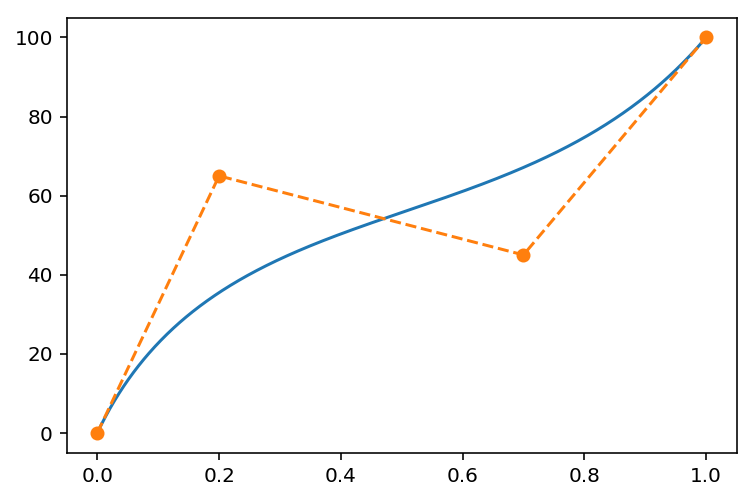

<Figure size 432x288 with 0 Axes>

In [43]:
### 制御点と対応するベジェ曲線のグラフ
plt.plot(P.T[0], P.T[1])
plt.plot(points.T[0], points.T[1], '--o')
plt.show()
plt.clf()